<a href="https://colab.research.google.com/github/profitmonk/TA-Lib.github.io/blob/main/train_quantize_measure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import torch
import time
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import *

%matplotlib inline

In [ ]:
batch_size = 400
epochs = 120
max_lr = 0.001
grad_clip = 0.01
weight_decay =0.001
opt_func = torch.optim.Adam

In [ ]:
train_data = torchvision.datasets.CIFAR100('./', train=True, download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

100%|██████████| 169001437/169001437 [01:31<00:00, 1851749.22it/s]


Extracting ./cifar-100-python.tar.gz to ./


In [ ]:
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])

In [ ]:
trainset = torchvision.datasets.CIFAR100("./",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size, shuffle=True, num_workers=2,pin_memory=True)

testset = torchvision.datasets.CIFAR100("./",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size*2,pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))

        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028
                                        nn.Linear(1028, num_classes)) # 1028 -> 100

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Initial evaluation
history = [evaluate(model, testloader)]
history

[{'val_loss': 4.605555534362793, 'val_acc': 0.012596153654158115}]

In [ ]:
# Fitting the first 1/4 epochs
current_time=time.time()
history += fit_one_cycle(int(epochs/4), max_lr, model, trainloader, testloader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 3.6312, val_loss: 3.1095, val_acc: 0.2471
Epoch [1], last_lr: 0.00015, train_loss: 2.8587, val_loss: 2.7697, val_acc: 0.3106
Epoch [2], last_lr: 0.00028, train_loss: 2.5120, val_loss: 2.7561, val_acc: 0.3095
Epoch [3], last_lr: 0.00044, train_loss: 2.2816, val_loss: 2.5610, val_acc: 0.3442
Epoch [4], last_lr: 0.00060, train_loss: 2.0792, val_loss: 2.5283, val_acc: 0.3765
Epoch [5], last_lr: 0.00076, train_loss: 1.9044, val_loss: 2.3713, val_acc: 0.3953
Epoch [6], last_lr: 0.00089, train_loss: 1.7636, val_loss: 2.3057, val_acc: 0.4294
Epoch [7], last_lr: 0.00097, train_loss: 1.6284, val_loss: 1.7903, val_acc: 0.5161
Epoch [8], last_lr: 0.00100, train_loss: 1.5035, val_loss: 1.9844, val_acc: 0.4770
Epoch [9], last_lr: 0.00099, train_loss: 1.3768, val_loss: 2.0206, val_acc: 0.4816
Epoch [10], last_lr: 0.00098, train_loss: 1.2874, val_loss: 1.8288, val_acc: 0.5124
Epoch [11], last_lr: 0.00095, train_loss: 1.1868, val_loss: 1.6171, val_acc: 0.5581
Ep

In [ ]:
# Collect training time and result
current_time = time.time()
result = evaluate(model, testloader)
result
print('Training time: {:.2f} s'.format(time.time() - current_time))

Training time: 2.96 s


In [ ]:
# Saving the model to h5 file
torch.save(model.state_dict(), 'group22_pretrained_model.h5')

In [ ]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

y_test, y_pred = test_label_predictions(model, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[88  0  1 ...  0  1  0]
 [ 0 85  0 ...  0  0  0]
 [ 0  0 58 ...  0  4  1]
 ...
 [ 0  0  0 ... 77  0  0]
 [ 0  0  4 ...  0 59  0]
 [ 0  0  1 ...  0  0 77]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       100
           1       0.85      0.85      0.85       100
           2       0.59      0.58      0.58       100
           3       0.67      0.66      0.67       100
           4       0.55      0.63      0.59       100
           5       0.81      0.73      0.77       100
           6       0.73      0.86      0.79       100
           7       0.75      0.77      0.76       100
           8       0.90      0.89      0.89       100
           9       0.81      0.76      0.78       100
          10       0.62      0.52      0.57       100
          11       0.56      0.52      0.54       100
          12       0.76      0.83      0.79       100
          13       0.70      0.62      0.66       100
          14   

In [ ]:
print(cm)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = range(100))

[[88  0  1 ...  0  1  0]
 [ 0 85  0 ...  0  0  0]
 [ 0  0 58 ...  0  4  1]
 ...
 [ 0  0  0 ... 77  0  0]
 [ 0  0  4 ...  0 59  0]
 [ 0  0  1 ...  0  0 77]]


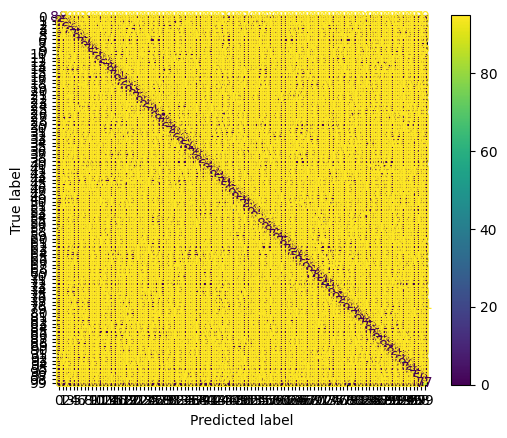

In [ ]:
import matplotlib.pyplot as plt
cm_display
cm_display.plot()
plt.show()

In [ ]:
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       100
           1       0.85      0.85      0.85       100
           2       0.59      0.58      0.58       100
           3       0.67      0.66      0.67       100
           4       0.55      0.63      0.59       100
           5       0.81      0.73      0.77       100
           6       0.73      0.86      0.79       100
           7       0.75      0.77      0.76       100
           8       0.90      0.89      0.89       100
           9       0.81      0.76      0.78       100
          10       0.62      0.52      0.57       100
          11       0.56      0.52      0.54       100
          12       0.76      0.83      0.79       100
          13       0.70      0.62      0.66       100
          14       0.67      0.73      0.70       100
          15       0.72      0.82      0.77       100
          16       0.74      0.74      0.74       100
          17       0.91    

This whole script flow is coming in from kaggle - https://www.kaggle.com/code/yiweiwangau/cifar-100-resnet-pytorch-75-17-accuracy

The confusion matrix calculation is from https://www.w3schools.com/python/python_ml_confusion_matrix.asp